### 1. Data Review & Cleaning

#### 1.1. Initial review - data shape, type & content

In [2]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import squarify  # to draw treemap in matplotlib

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [3]:
# We noticed the data doesn't have column names, so we'll read it without adding
# headers and add the column names afterwards

data = pd.read_csv('creditcardmarketing.csv', header=None)

columns = ['customer_number', 'offer_accepted', 'reward', 'mailer_type', \
    'income_level', 'bank_accounts_open', 'overdraft_protection', \
    'credit_rating', 'credit_cards_held', 'homes_owned', 'household_size', \
    'home_owner', 'average_balance', 'balance_Q1', 'balance_Q2', 'balance_Q3', \
    'balance_Q4']

data.columns = columns

In [4]:
# Check characteristics of the data
data.shape

(18000, 17)

In [5]:
data.dtypes

customer_number           int64
offer_accepted           object
reward                   object
mailer_type              object
income_level             object
bank_accounts_open        int64
overdraft_protection     object
credit_rating            object
credit_cards_held         int64
homes_owned               int64
household_size            int64
home_owner               object
average_balance         float64
balance_Q1              float64
balance_Q2              float64
balance_Q3              float64
balance_Q4              float64
dtype: object

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18000 entries, 0 to 17999
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   customer_number       18000 non-null  int64  
 1   offer_accepted        18000 non-null  object 
 2   reward                18000 non-null  object 
 3   mailer_type           18000 non-null  object 
 4   income_level          18000 non-null  object 
 5   bank_accounts_open    18000 non-null  int64  
 6   overdraft_protection  18000 non-null  object 
 7   credit_rating         18000 non-null  object 
 8   credit_cards_held     18000 non-null  int64  
 9   homes_owned           18000 non-null  int64  
 10  household_size        18000 non-null  int64  
 11  home_owner            18000 non-null  object 
 12  average_balance       17976 non-null  float64
 13  balance_Q1            17976 non-null  float64
 14  balance_Q2            17976 non-null  float64
 15  balance_Q3         

We can already see that in the balance columns there are 24 null values.

In [7]:
round(data.describe())

,customer_number,bank_accounts_open,credit_cards_held,homes_owned,household_size,average_balance,balance_Q1,balance_Q2,balance_Q3,balance_Q4
count,18000.0,18000.0,18000.0,18000.0,18000.0,17976.0,17976.0,17976.0,17976.0,17976.0
mean,9000.0,1.0,2.0,1.0,3.0,941.0,910.0,999.0,1042.0,810.0
std,5196.0,0.0,1.0,0.0,1.0,350.0,620.0,457.0,553.0,559.0
min,1.0,1.0,1.0,1.0,1.0,48.0,0.0,0.0,0.0,0.0
25%,4501.0,1.0,1.0,1.0,3.0,788.0,393.0,663.0,633.0,363.0
50%,9000.0,1.0,2.0,1.0,3.0,1007.0,772.0,1032.0,946.0,703.0
75%,13500.0,1.0,2.0,1.0,4.0,1153.0,1521.0,1342.0,1463.0,1212.0
max,18000.0,3.0,4.0,3.0,9.0,3366.0,3450.0,3421.0,3823.0,4215.0


In [8]:
data.head(5)

,customer_number,offer_accepted,reward,mailer_type,income_level,bank_accounts_open,overdraft_protection,credit_rating,credit_cards_held,homes_owned,household_size,home_owner,average_balance,balance_Q1,balance_Q2,balance_Q3,balance_Q4
0,1,No,Air Miles,Letter,High,1,No,High,2,1,4,No,1160.75,1669.0,877.0,1095.0,1002.0
1,2,No,Air Miles,Letter,Medium,1,No,Medium,2,2,5,Yes,147.25,39.0,106.0,78.0,366.0
2,3,No,Air Miles,Postcard,High,2,No,Medium,2,1,2,Yes,276.50,367.0,352.0,145.0,242.0
3,4,No,Air Miles,Letter,Medium,2,No,High,1,1,4,No,1219.00,1578.0,1760.0,1119.0,419.0
4,5,No,Air Miles,Letter,Medium,1,No,Medium,2,1,6,Yes,1211.00,2140.0,1357.0,982.0,365.0


We notice the `customer_column` which we can use as our index column after ensuring it doesn't have any duplicate values:

In [9]:
print(len(data['customer_number'].unique())/data.shape[0]) # equal to 1, so no duplicates

1.0


In [10]:
data.set_index('customer_number', inplace=True, drop=True)

In [11]:
# Check the unique values in the categorical columns:
cat = data.select_dtypes(object)

for col in cat.columns:
    print(col, ":", cat[col].unique()) # No odd entries, so no cleaning required

offer_accepted : ['No' 'Yes']
reward : ['Air Miles' 'Cash Back' 'Points']
mailer_type : ['Letter' 'Postcard']
income_level : ['High' 'Medium' 'Low']
overdraft_protection : ['No' 'Yes']
credit_rating : ['High' 'Medium' 'Low']
home_owner : ['No' 'Yes']


In [12]:
# Check the unique values in the discrete numerical columns

# Split the numerical data into discrete & continuous data
def split_numericals(data, threshold=10):
    num = data.select_dtypes(np.number)
    cont_columns = []
    disc_columns = []
    for col in num.columns:
        if len(num[col].unique()) > threshold:
            cont_columns.append(col)
        else:
            disc_columns.append(col)
    num_cont = data.loc[:, cont_columns]
    num_disc = data.loc[:, disc_columns]
    return num_cont, num_disc

num_cont, num_disc = split_numericals(data)

# Check the unique values
for col in num_disc.columns:
    print(col, ":", num_disc[col].unique()) # No odd entries, so no cleaning required

bank_accounts_open : [1 2 3]
credit_cards_held : [2 1 3 4]
homes_owned : [1 2 3]
household_size : [4 5 2 6 3 1 8 9]


#### 1.2. Data Cleaning

As the data set is already relatively clean and the data types are correct, we only need to handle the null values in the balance columns. We will start by checking the maximum percentage of nulls within a row, to decide whether or not it would be more beneficial to remove them from the dataset.

In [13]:
def max_nulls_rows(df):
    nulls_percentage = []
    for index in df.index:
        number_of_nulls = df.loc[index,].isna().sum()
        null_percentage = round(number_of_nulls * 100 / df.shape[1], 1)
        nulls_percentage.append(null_percentage)
    return max(nulls_percentage)

max_nulls_rows(data)

31.2

Given some rows have 31% null values, it might be better to drop them:

In [14]:
data = data.dropna()

In [15]:
data.shape # We can see we dropped the customers with NaN values across \
           # all balance columns

(17976, 16)

### 2. Exploratory Data Analysis

#### 2.1. Categorical & discrete numerical columns

In [19]:
# Check number of plots
print("cat column number:", cat.shape[1])
print("num_disc column number:", num_disc.shape[1])

cat column number: 7
num_disc column number: 4


In [43]:
def column_plotter(cat_or_num_disc, plot_type=sns.countplot):
    col_number = len(cat_or_num_disc.columns)
    for i in range(0, col_number, 2):
        column_1 = cat_or_num_disc.columns[i]
        try:
            column_2 = cat_or_num_disc.columns[i + 1]
            fig, ax = plt.subplots(1, 2, figsize=(12, 4))        
            plot_type(x=column_2, data=cat_or_num_disc, ax=ax[1], color='b')
            plot_type(x=column_1, data=cat_or_num_disc, ax=ax[0], color='c')        
        except:
            fig, ax = plt.subplots(1, 1, figsize=(6, 4))  
            plot_type(x=column_1, data=cat_or_num_disc, color='c')              
        plt.show()

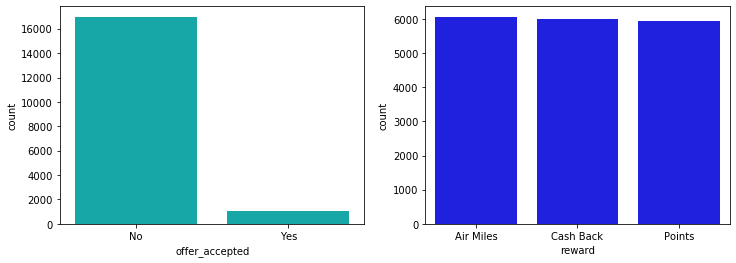

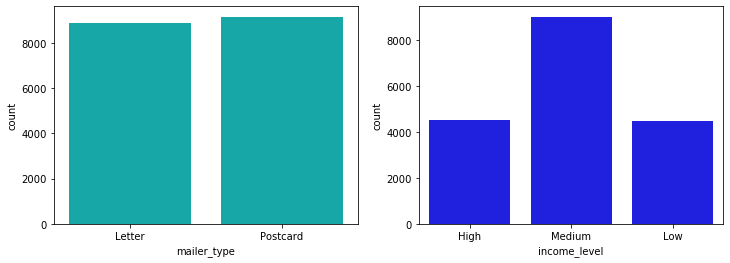

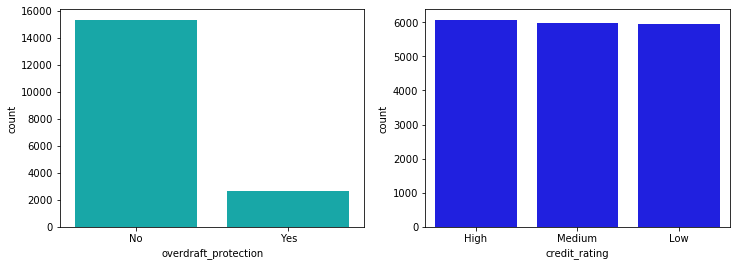

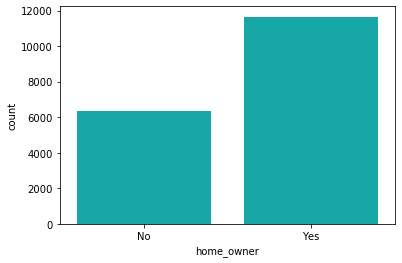

In [44]:
column_plotter(cat)

We notice that the `offer_accepted`, `overdraft_protection`, and `home_owner` are imbalanced.

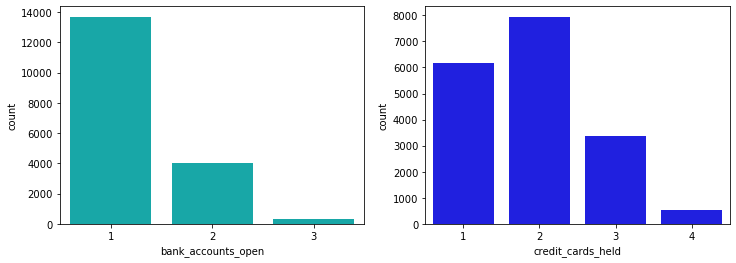

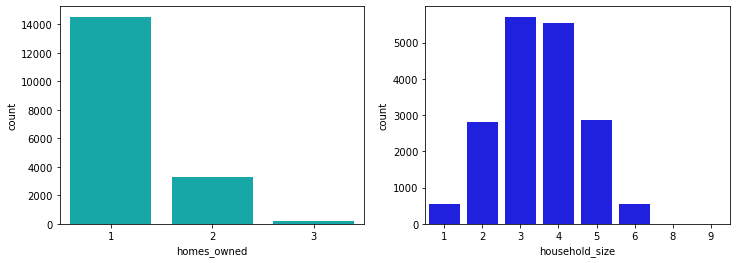

In [45]:
column_plotter(num_disc)

We notice we have a very small representation of customers that:
- have 3 open bank accounts
* have 4 credit card accounts
- own 3 houses
* belong to a household of more than 6 people

#### 2.2. Numerical continuous data

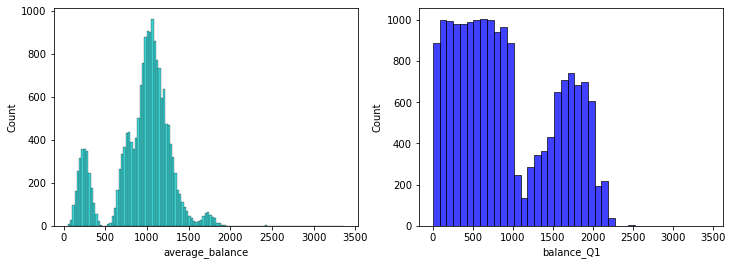

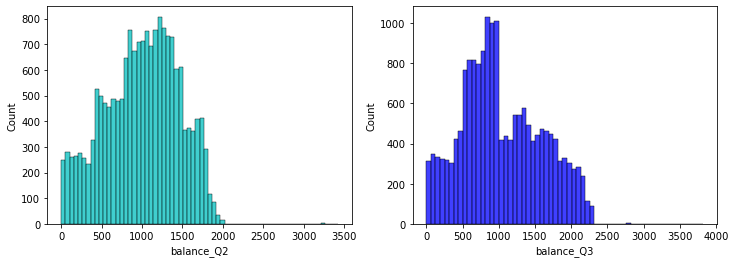

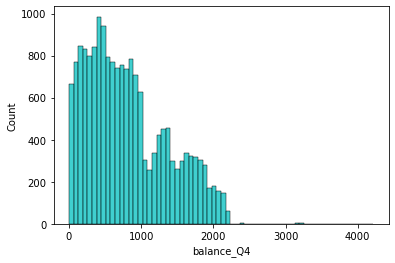

In [46]:
column_plotter(num_cont, plot_type=sns.histplot)

We note that the average, Q2 & Q3 balances have relatively normal distributions, whereas the Q1 & Q4 balances generally tend to be on the lower side.

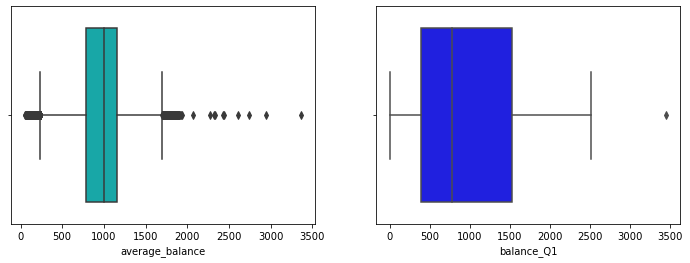

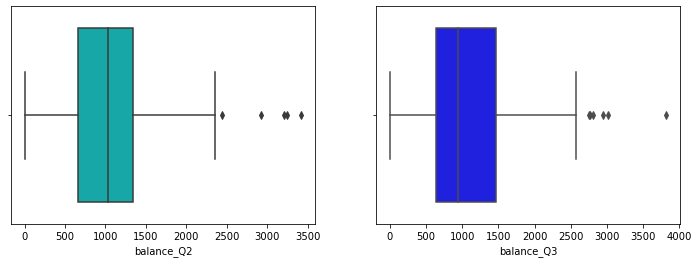

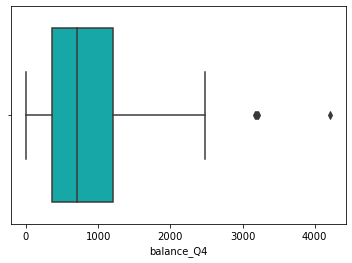

In [47]:
column_plotter(num_cont, plot_type=sns.boxplot)

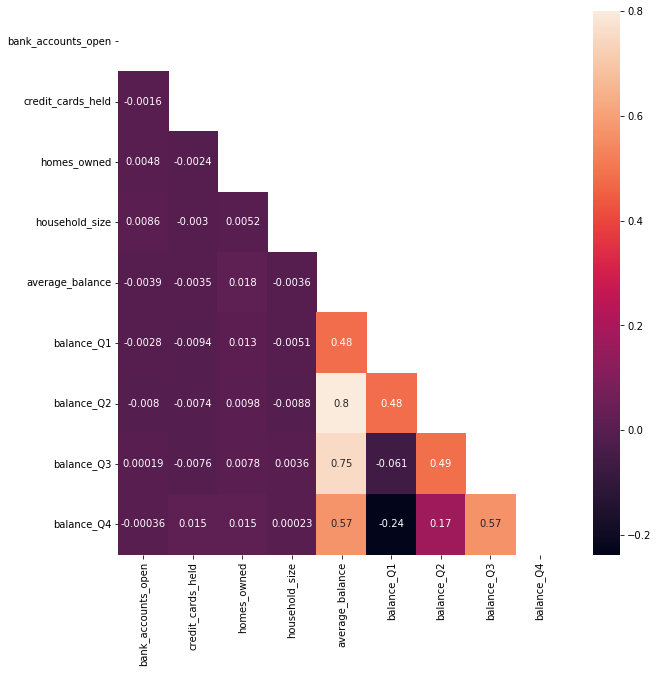

In [51]:
# Calculate correlation matrix
data.corr()

# Create heatmap
mask = np.zeros_like(data.corr())
mask[np.triu_indices_from(mask)] = True 
fig, ax = plt.subplots(figsize=(10, 10))
ax = sns.heatmap(data.corr(), mask=mask, annot=True)
plt.show()

We notice that the `average_balance` is highly correlated with all the other balances (which is to be expected), whereas the quarterly balance is highly correlated with the previous quarter's balance, which is again to be expected. In further modelling, we might want to use the `average_balance` rather than all the quarterly balances.

In [52]:
# Save clean dataframe to a new .csv file to be used in further analysis
data.to_csv('creditcardmarketing_post_cleaning.csv')